# Inteligent Credit Sentinel
## Overall Structure:

1.  **Load and Preprocess Data:** Common steps for all layers.
2.  **Layer 1: Rapid Anomaly Screener (Autoencoder)**
3.  **Layer 2: Fraud Likelihood Estimator (Gradient Boosting)**
4.  **Layer 3: Billing Anomaly Detector (Random Forest / Logistic Regression with NLP hints)**
5.  **Layer 4: Decision & Action Engine (Conceptual - Meta-Learner)**

We'll start with loading, preprocessing, and then Layer 1.

**Important Considerations Before Coding:**

*   **Feature Selection:** For each layer, we'll select relevant features from the simulated dataset. Not all generated features are useful for every layer.
*   **Train-Test Split:** Crucial for evaluating model performance. We should ideally split based on time if we want to simulate a real deployment, but for this initial prototype, a random split is acceptable. Let's use a time-based split as it's more robust.
*   **Evaluation Metrics:**
    *   **Anomaly Detection (Layer 1):** Reconstruction error distribution, AUC-ROC if we treat high reconstruction error as "positive class."
    *   **Classification (Layers 2 & 3):** Precision, Recall, F1-Score, AUC-ROC, Confusion Matrix. Particularly important for imbalanced classes (fraud, billing errors).
*   **Simplicity First:** We'll start with standard implementations. Hyperparameter tuning and more complex architectures can come later.

## Part 1: Load Data and Initial Preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# For Autoencoder (Layer 1)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# For Classification (Layers 2, 3)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix

# Load the dataset
try:
    df = pd.read_csv("/kaggle/input/simulated-credit-card-transactions/simulated_credit_card_transactions.csv")
except FileNotFoundError:
    print("Error: simulated_credit_card_transactions.csv not found. Make sure you've generated it.")
    exit()

print("Dataset loaded successfully.")
print(f"Shape of dataset: {df.shape}")
# df.head()

# --- Basic Data Cleaning and Type Conversion ---
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Identify categorical and numerical features (initial pass)
# We'll refine this per layer
categorical_features_initial = [
    'Merchant_Category_Code', 'Point_of_Sale_Entry_Mode', 'Transaction_Currency_Code',
    'Transaction_Country_Code', 'Country_Code_CH', # Cardholder's country
    'Persona_Type', 'Merchant_Risk_Level', 'AVS_Response_Code', 'CVV_Match_Result',
    'Billing_Error_Type', 'Transaction_DayOfWeek' # Hour is numerical but can be cyclical
]
# Ensure all potential categoricals are string type for one-hot encoding
for col in categorical_features_initial:
    if col in df.columns:
        df[col] = df[col].astype(str).fillna('Missing') # Fill NaN before one-hot

numerical_features_initial = [
    'Transaction_Amount_Local_Currency', 'Is_Card_Present', 'Is_Cross_Border_Transaction',
    'Credit_Limit', 'Reported_Fraud_History_Count', 'Billing_Dispute_History_Count',
    'Historical_Fraud_Rate_Global', 'Historical_Billing_Dispute_Rate_Global',
    'CH_Avg_Amount', 'CH_Median_Amount', 'CH_StdDev_Amount', 'CH_Transaction_Amount_ZScore',
    'CH_Frequency_MCC_Usage', 'CH_Count_Transactions_per_Day',
    'Time_Since_CH_Last_Transaction_Overall_Min', 'Time_Since_CH_Last_Transaction_at_Same_Merchant_Min',
    'Transaction_Hour'
]
# Add windowed features
window_sizes_hours = [1, 6, 24, 168]
for window_hr in window_sizes_hours:
    numerical_features_initial.append(f'CH_Count_Transactions_Last_{window_hr}H')
    numerical_features_initial.append(f'CH_Sum_Amount_Transactions_Last_{window_hr}H')
    numerical_features_initial.append(f'CH_Count_Unique_Merchants_Last_{window_hr}H')

# Keep only existing columns
numerical_features_initial = [col for col in numerical_features_initial if col in df.columns]
categorical_features_initial = [col for col in categorical_features_initial if col in df.columns]


# --- Time-based Train-Test Split ---
# Sort by timestamp to ensure chronological split
df = df.sort_values('Timestamp').reset_index(drop=True)
split_point = int(len(df) * 0.8) # 80% for training, 20% for testing

train_df = df.iloc[:split_point].copy()
test_df = df.iloc[split_point:].copy()

print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print(f"Train time range: {train_df['Timestamp'].min()} to {train_df['Timestamp'].max()}")
print(f"Test time range: {test_df['Timestamp'].min()} to {test_df['Timestamp'].max()}")

# --- Define Target Variables ---
TARGET_FRAUD = 'Is_Fraud'
TARGET_BILLING_ERROR = 'Is_Billing_Error'

# --- Preprocessing Pipelines (will be adapted per layer) ---
# Numerical transformer
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Median is robust to outliers
    ('scaler', StandardScaler()) # Standardize features
])

# Categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse_output=False for easier use with Keras
])

print("Initial data loading and preprocessing setup complete.")

2025-08-14 19:44:55.440223: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755200695.712629      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755200695.790328      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Dataset loaded successfully.
Shape of dataset: (75000, 49)
Train set shape: (60000, 49)
Test set shape: (15000, 49)
Train time range: 2023-01-01 00:02:41 to 2023-05-25 01:56:15
Test time range: 2023-05-25 01:58:36 to 2023-06-29 23:54:04
Initial data loading and preprocessing setup complete.


## Part 2: Layer 1 - Rapid Anomaly Screener (Autoencoder)
The goal here is to train an autoencoder on normal (non-fraud, non-billing_error) transactions from the training set. Then, we'll use it to get reconstruction errors for all transactions in the test set. High reconstruction error suggests an anomaly.


--- Layer 1: Rapid Anomaly Screener (Autoencoder) - IMPROVED WORKFLOW ---
Original Train shape: (60000, 49)
New L1 Train shape: (48000, 49)
New L1 Validation shape: (12000, 49)
Final Test shape: (15000, 49)


[I 2025-08-14 19:45:10,519] A new study created in memory with name: no-name-58491b40-f37f-48ea-8235-d877568e7acb


Input dimension for Autoencoder: 232

Starting Hyperparameter Optimization with Optuna...


I0000 00:00:1755200711.845843      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1755200716.973336      57 service.cc:148] XLA service 0x7ad93c0021f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755200716.974183      57 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755200717.395433      57 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755200720.173405      57 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
[I 2025-08-14 19:45:27,375] Trial 0 finished with value: 0.07579563618342801 and parameters: {'n_layers': 3, 'learning_rate': 0.007095793078822357, 'dropout_rate': 0.18857474444859182, 'n_units_encoder_l0': 125, 'n_units_encoder_l1'


Optimization finished.
Best trial PR-AUC: 0.2052723830516319
Best hyperparameters found: {'n_layers': 1, 'learning_rate': 0.0014534840011835748, 'dropout_rate': 0.26277588932075935, 'n_units_encoder_l0': 61}


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_84 (Dense)                     │ (None, 61)                  │          14,213 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_64 (Dropout)                 │ (None, 61)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 61)                  │           3,782 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_65 (Dropout)                 │ (None, 61)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 232)                 │          14,384 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,379 (126.48 KB)

 Trainable params: 32,379 (126.48 KB)

 Non-trainable params: 0 (0.00 B)


Training final best model on all normal training data...
Epoch 1/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0973
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0157
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0133
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112
Epoch 5/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0100
Epoch 6/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093
Epoch 7/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0087
Epoch 8/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0083
Epoch 9/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081
Epoch 10/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077
Epoch 11/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075
Epoch 12/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072
Epoch 13/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070
Epoch 14/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


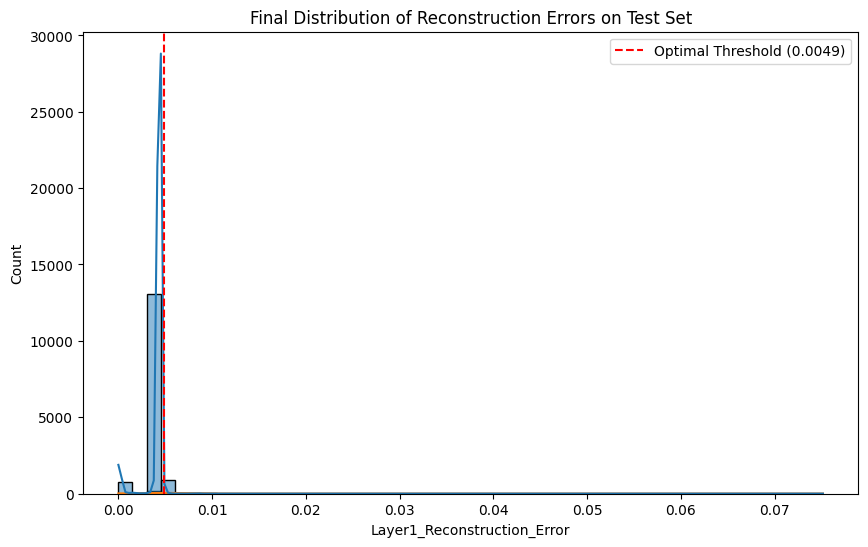

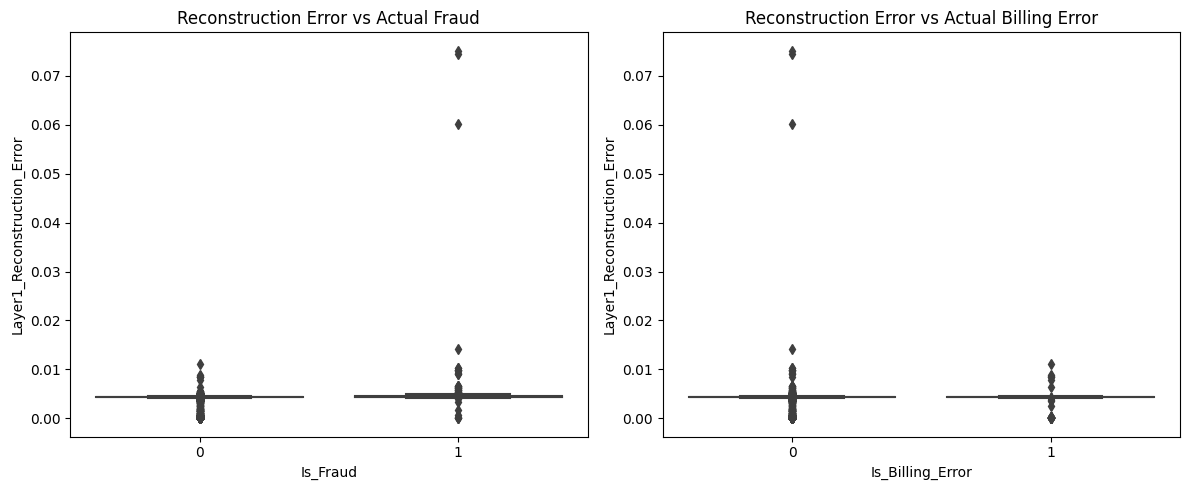


Final Layer 1 Anomaly Flagging Report (on Test Set):
Comparison with Actual Fraud:
Is_Fraud                    0    1
Layer1_Is_Anomaly_Flag            
0                       14721  187
1                          55   37

Comparison with Actual Billing Errors:
Is_Billing_Error            0    1
Layer1_Is_Anomaly_Flag            
0                       14726  182
1                          85    7


In [2]:
# ==============================================================================
# --- Layer 1: Rapid Anomaly Screener (Autoencoder) - IMPROVED VERSION ---
# ==============================================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Import Optuna for hyperparameter tuning
try:
    import optuna
except ImportError:
    print("Optuna not found. Please install it: pip install optuna")
    # If running in a notebook without internet, this will fail.
    # In that case, you'd have to manually tune parameters.
    exit()

print("\n--- Layer 1: Rapid Anomaly Screener (Autoencoder) - IMPROVED WORKFLOW ---")

# --- 1. Refined Data Splitting (Train / Validation / Test) ---
# We already have train_df and test_df from the initial split.
# Let's create a validation set from the train_df.
train_df_l1, val_df_l1 = train_test_split(
    train_df,
    test_size=0.2, # Use 20% of the original training data as a validation set
    shuffle=False  # Keep time-based order
)

print(f"Original Train shape: {train_df.shape}")
print(f"New L1 Train shape: {train_df_l1.shape}")
print(f"New L1 Validation shape: {val_df_l1.shape}")
print(f"Final Test shape: {test_df.shape}")


# --- 2. Feature Selection & Preprocessing Setup ---
# We'll use the same feature set as before.
layer1_numerical_features = [
    'Transaction_Amount_Local_Currency', 'Is_Card_Present',
    'CH_Avg_Amount', 'CH_Median_Amount', 'CH_StdDev_Amount', 'CH_Transaction_Amount_ZScore',
    'CH_Frequency_MCC_Usage', 'CH_Count_Transactions_per_Day', 'Transaction_Hour'
]
layer1_categorical_features = [
    'Merchant_Category_Code', 'Point_of_Sale_Entry_Mode', 'Transaction_Currency_Code',
    'Transaction_Country_Code', 'Persona_Type', 'Transaction_DayOfWeek'
]
layer1_numerical_features = [f for f in layer1_numerical_features if f in train_df.columns]
layer1_categorical_features = [f for f in layer1_categorical_features if f in train_df.columns]

# Create preprocessor with MinMaxScaler, which is better for Autoencoders
numerical_transformer_minmax = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor_l1_minmax = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_minmax, layer1_numerical_features),
        ('cat', categorical_transformer, layer1_categorical_features)
    ],
    remainder='drop'
)

# Prepare the data splits
# IMPORTANT: Train the preprocessor ONLY on the training data.
normal_train_df_l1 = train_df_l1[(train_df_l1[TARGET_FRAUD] == 0) & (train_df_l1[TARGET_BILLING_ERROR] == 0)]
X_train_normal_scaled = preprocessor_l1_minmax.fit_transform(normal_train_df_l1)

# Transform validation and test sets
X_val_scaled = preprocessor_l1_minmax.transform(val_df_l1)
y_val_fraud = val_df_l1[TARGET_FRAUD] # We need the "ground truth" for optimization

X_test_scaled = preprocessor_l1_minmax.transform(test_df)
y_test_fraud = test_df[TARGET_FRAUD]
y_test_billing_error = test_df[TARGET_BILLING_ERROR]

input_dim = X_train_normal_scaled.shape[1]
print(f"Input dimension for Autoencoder: {input_dim}")


# --- 3. Hyperparameter Optimization with Optuna ---

def objective(trial):
    """
    This function will be called by Optuna to train and evaluate a model.
    Optuna will try to maximize the return value of this function.
    """
    # Suggest hyperparameters to Optuna
    n_layers = trial.suggest_int('n_layers', 1, 3) # Number of encoder/decoder hidden layers
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
    # Build the model
    model_layers = [Input(shape=(input_dim,))]
    
    # Encoder layers
    last_layer_neurons = input_dim
    for i in range(n_layers):
        neurons = trial.suggest_int(f'n_units_encoder_l{i}', 32, 256, log=True)
        # Ensure layers get smaller
        neurons = min(neurons, last_layer_neurons)
        model_layers.append(Dense(neurons, activation='relu'))
        model_layers.append(Dropout(dropout_rate))
        last_layer_neurons = neurons

    # Decoder layers (mirrors the encoder)
    for i in range(n_layers - 1, -1, -1):
        neurons = model_layers[i * 2 + 1].units # Get neuron count from corresponding encoder layer
        model_layers.append(Dense(neurons, activation='relu'))
        model_layers.append(Dropout(dropout_rate))

    model_layers.append(Dense(input_dim, activation='sigmoid'))
    
    model = Sequential(model_layers)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    
    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(
        X_train_normal_scaled, X_train_normal_scaled,
        epochs=50, # Shorter epochs for faster tuning
        batch_size=256,
        shuffle=True,
        validation_split=0.1, # Inner validation split for training stability
        callbacks=[early_stopping],
        verbose=0 # Suppress output during tuning
    )
    
    # Evaluate on our dedicated validation set
    X_val_pred = model.predict(X_val_scaled, verbose=0)
    val_mse = np.mean(np.power(X_val_scaled - X_val_pred, 2), axis=1)
    
    # Calculate PR-AUC, our optimization metric
    precision, recall, _ = precision_recall_curve(y_val_fraud, val_mse)
    pr_auc_score = auc(recall, precision)
    
    return pr_auc_score

# Create and run the Optuna study
print("\nStarting Hyperparameter Optimization with Optuna...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20) # Run 20 different trials to find the best params

print("\nOptimization finished.")
print("Best trial PR-AUC:", study.best_value)
print("Best hyperparameters found:", study.best_params)

# --- 4. Build, Train, and Evaluate the Best Model ---

# Get the best parameters from the study
best_params = study.best_params
best_n_layers = best_params['n_layers']
best_learning_rate = best_params['learning_rate']
best_dropout_rate = best_params['dropout_rate']

# Build the final model architecture with the best params
final_model_layers = [Input(shape=(input_dim,))]
last_layer_neurons = input_dim
for i in range(best_n_layers):
    neurons = best_params[f'n_units_encoder_l{i}']
    final_model_layers.append(Dense(neurons, activation='relu'))
    final_model_layers.append(Dropout(best_dropout_rate))
    last_layer_neurons = neurons

for i in range(best_n_layers - 1, -1, -1):
    neurons = final_model_layers[i * 2 + 1].units
    final_model_layers.append(Dense(neurons, activation='relu'))
    final_model_layers.append(Dropout(best_dropout_rate))

final_model_layers.append(Dense(input_dim, activation='sigmoid'))

final_autoencoder = Sequential(final_model_layers)
final_autoencoder.compile(optimizer=Adam(learning_rate=best_learning_rate), loss='mse')
final_autoencoder.summary()

# Train the final model on ALL normal training data (no validation split needed here)
print("\nTraining final best model on all normal training data...")
final_autoencoder.fit(
    X_train_normal_scaled, X_train_normal_scaled,
    epochs=100, # Train for longer now that we have the best params
    batch_size=256,
    shuffle=True,
    callbacks=[EarlyStopping(monitor='loss', patience=10)], # Monitor training loss directly
    verbose=1
)

# --- 5. Find Optimal Threshold on Validation Set ---
X_val_pred_final = final_autoencoder.predict(X_val_scaled)
val_mse_final = np.mean(np.power(X_val_scaled - X_val_pred_final, 2), axis=1)

precision, recall, thresholds = precision_recall_curve(y_val_fraud, val_mse_final)
f1_scores = np.nan_to_num(2 * (precision * recall) / (precision + recall))

best_threshold_idx = np.argmax(f1_scores)
OPTIMIZED_THRESHOLD = thresholds[best_threshold_idx]
print(f"\nOptimal Anomaly Threshold (found on validation set): {OPTIMIZED_THRESHOLD:.6f}")


# --- 6. Final Evaluation on the Unseen Test Set ---
print("\n--- Final Performance Evaluation on Test Set ---")
X_test_pred = final_autoencoder.predict(X_test_scaled)
test_mse = np.mean(np.power(X_test_scaled - X_test_pred, 2), axis=1)

# Add results to the main test_df for analysis and use by Layer 4
test_df['Layer1_Reconstruction_Error'] = test_mse
test_df['Layer1_Is_Anomaly_Flag'] = (test_df['Layer1_Reconstruction_Error'] > OPTIMIZED_THRESHOLD).astype(int)

# Plot final distributions
plt.figure(figsize=(10, 6))
sns.histplot(data=test_df, x='Layer1_Reconstruction_Error', hue=TARGET_FRAUD, bins=50, kde=True)
plt.title('Final Distribution of Reconstruction Errors on Test Set')
plt.axvline(OPTIMIZED_THRESHOLD, color='r', linestyle='--', label=f'Optimal Threshold ({OPTIMIZED_THRESHOLD:.4f})')
plt.legend()
plt.show()

# Boxplots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=test_df[TARGET_FRAUD], y=test_df['Layer1_Reconstruction_Error'])
plt.title('Reconstruction Error vs Actual Fraud')

plt.subplot(1, 2, 2)
sns.boxplot(x=test_df[TARGET_BILLING_ERROR], y=test_df['Layer1_Reconstruction_Error'])
plt.title('Reconstruction Error vs Actual Billing Error')
plt.tight_layout()
plt.show()

# Final flagging report on test set
print("\nFinal Layer 1 Anomaly Flagging Report (on Test Set):")
print("Comparison with Actual Fraud:")
print(pd.crosstab(test_df['Layer1_Is_Anomaly_Flag'], y_test_fraud))
print("\nComparison with Actual Billing Errors:")
print(pd.crosstab(test_df['Layer1_Is_Anomaly_Flag'], y_test_billing_error))

**Explanation of Layer 1 Code:**

1.  **Feature Selection:** We pick features relevant for general anomaly detection – core transaction details and how they deviate from the cardholder's norm.
2.  **Preprocessor (`preprocessor_l1_minmax`):**
    *   `MinMaxScaler` is used for numerical features because autoencoders with sigmoid activation in the output layer typically expect inputs scaled between 0 and 1.
    *   `OneHotEncoder` converts categorical features into numerical format.
3.  **Data Preparation:**
    *   The autoencoder is trained *only* on transactions from `train_df` that are marked as `Is_Fraud == 0` AND `Is_Billing_Error == 0`. This teaches the autoencoder what "normal" looks like.
4.  **Autoencoder Architecture:**
    *   A simple feedforward neural network with an "encoder" part (reducing dimensionality) and a "decoder" part (reconstructing the input).
    *   `relu` activation is common in hidden layers.
    *   `sigmoid` activation in the output layer matches the 0-1 scaled input.
    *   `mse` (Mean Squared Error) is used as the loss function, aiming to minimize the difference between input and reconstructed output.
5.  **Training:**
    *   `EarlyStopping` is used to prevent overfitting and stop training when validation loss stops improving.
6.  **Reconstruction Error:**
    *   After training, the autoencoder is used to reconstruct all transactions in the `test_df`.
    *   The MSE between the original (scaled) test data and its reconstruction is calculated for each transaction. This is our anomaly score.
7.  **Evaluation:**
    *   Histograms and boxplots help visualize the distribution of reconstruction errors and see if they differ for fraudulent/billing error transactions.
8.  **Anomaly Threshold:** A common way to flag anomalies is to set a threshold on the reconstruction error. We calculate the 95th percentile of reconstruction errors on the *normal training data* and use that as a threshold. Transactions in the test set with errors above this threshold are flagged as anomalous by Layer 1.
9.  **Output:** The `Layer1_Reconstruction_Error` and `Layer1_Is_Anomaly_Flag` are added to `test_df`. These will be important inputs/features for later layers or the final decision engine.

---

Next, we'll move to Layer 2 (Fraud Likelihood Estimator). This layer will use supervised learning.

## Part 3: Layer 2- Fraud Likelihood Estimator.
This layer takes transactions (potentially all, or those flagged as anomalous by Layer 1, though for a robust system, it's often better to score all for Layer 2) and predicts the probability of them being fraudulent. This is a supervised classification task. We'll use GradientBoostingClassifier as it's generally powerful for tabular data.


--- Layer 2: Fraud Likelihood Estimator (Gradient Boosting) ---
Shape of preprocessed training data for L2: (60000, 269)
Shape of preprocessed test data for L2: (15000, 269)
Fraud ratio in L2 training data: 
Is_Fraud
0    0.984983
1    0.015017
Name: proportion, dtype: float64

Training Layer 2 Gradient Boosting model for Fraud Detection...
Layer 2 model training complete.

Layer 2 Fraud Detection Performance (on Test Set):
              precision    recall  f1-score   support

   Not Fraud       0.99      1.00      1.00     14776
       Fraud       0.84      0.63      0.72       224

    accuracy                           0.99     15000
   macro avg       0.91      0.82      0.86     15000
weighted avg       0.99      0.99      0.99     15000

Layer 2 ROC AUC Score: 0.9657


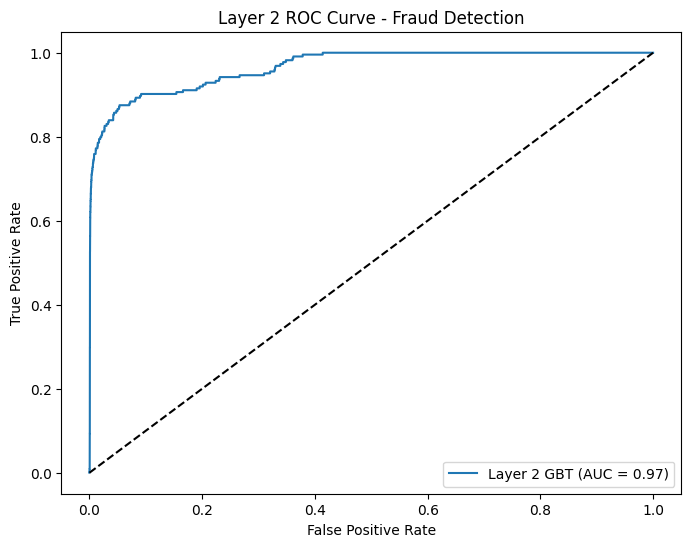

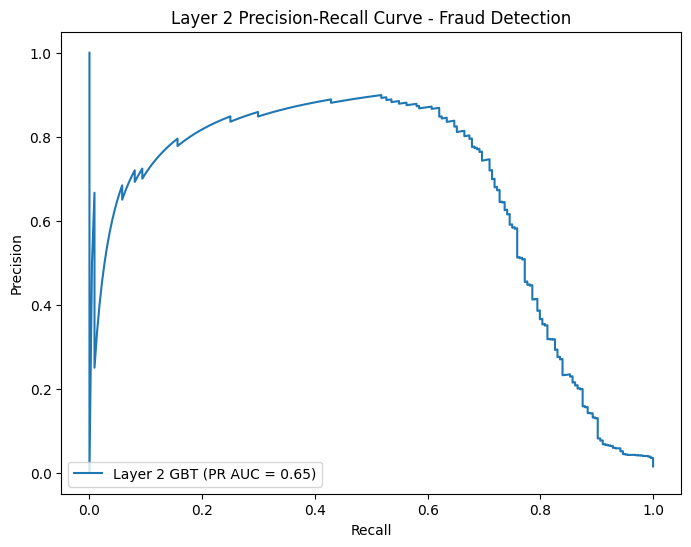

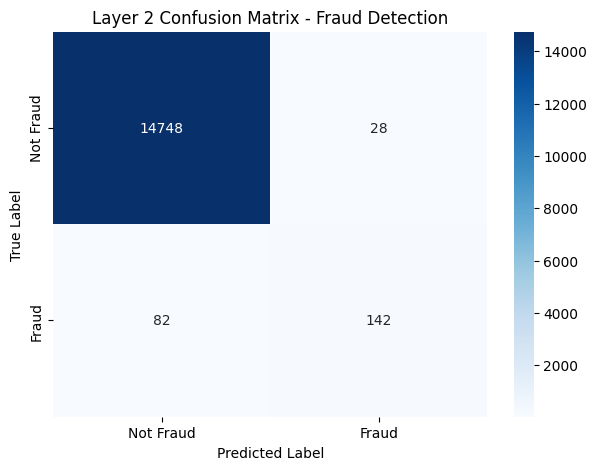

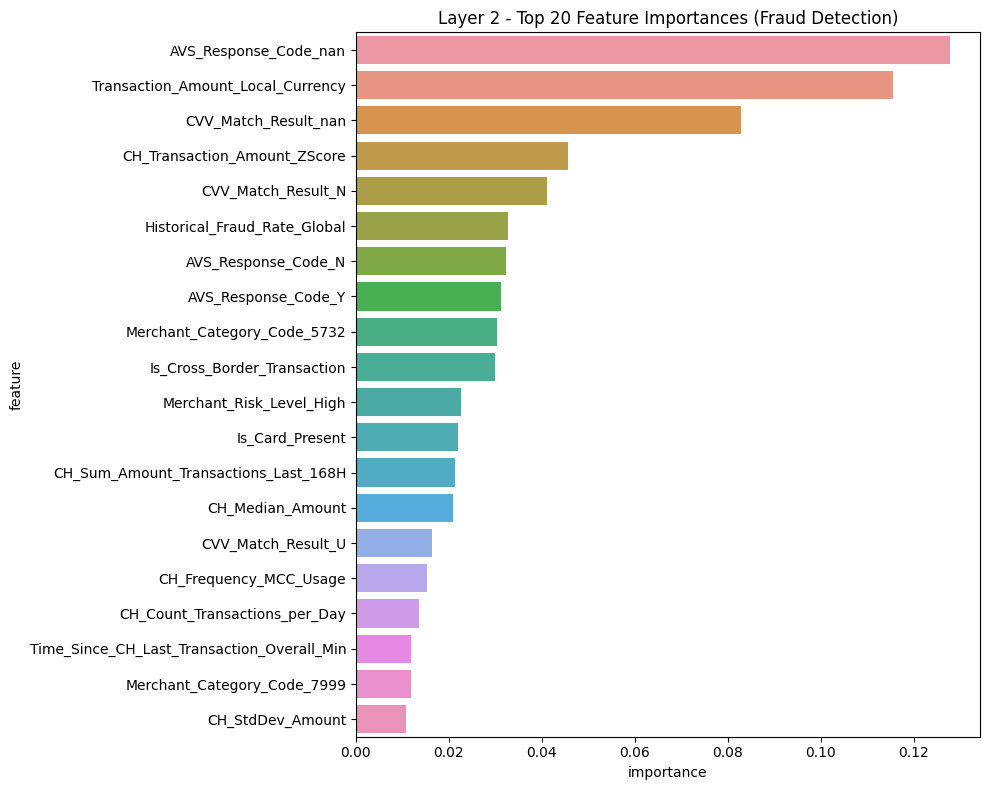

In [3]:
print("\n--- Layer 2: Fraud Likelihood Estimator (Gradient Boosting) ---")

# --- Feature Selection for Layer 2 ---
# More comprehensive set of features, including velocity, merchant risk, CNP details
layer2_numerical_features = [
    'Transaction_Amount_Local_Currency', 'Is_Card_Present', 'Is_Cross_Border_Transaction',
    'Credit_Limit', 'Reported_Fraud_History_Count', # CH specific risk
    'Historical_Fraud_Rate_Global', # Merchant specific risk
    'CH_Avg_Amount', 'CH_Median_Amount', 'CH_StdDev_Amount', 'CH_Transaction_Amount_ZScore',
    'CH_Frequency_MCC_Usage', 'CH_Count_Transactions_per_Day',
    'Time_Since_CH_Last_Transaction_Overall_Min',
    'Time_Since_CH_Last_Transaction_at_Same_Merchant_Min',
    'Transaction_Hour'
]
# Add windowed velocity features
for window_hr in window_sizes_hours: # Defined in Part 1
    layer2_numerical_features.append(f'CH_Count_Transactions_Last_{window_hr}H')
    layer2_numerical_features.append(f'CH_Sum_Amount_Transactions_Last_{window_hr}H')
    layer2_numerical_features.append(f'CH_Count_Unique_Merchants_Last_{window_hr}H')

layer2_categorical_features = [
    'Merchant_Category_Code', 'Point_of_Sale_Entry_Mode', 'Transaction_Currency_Code',
    'Transaction_Country_Code', 'Country_Code_CH',
    'Persona_Type', 'Merchant_Risk_Level',
    'AVS_Response_Code', 'CVV_Match_Result', 'Transaction_DayOfWeek'
]

# Include Layer 1's output if available (assuming Layer 1 ran on train_df too)
# For this prototype, we'll train Layer 2 independently first.
# Later, Layer 1's output on the *training data* could be a feature.
# For now, let's assume Layer 1's output is only on test_df.

# Ensure selected features exist
layer2_numerical_features = [f for f in layer2_numerical_features if f in train_df.columns]
layer2_categorical_features = [f for f in layer2_categorical_features if f in train_df.columns]

# --- Create Preprocessor for Layer 2 ---
# Using StandardScaler for numerical features for GBT
preprocessor_l2 = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, layer2_numerical_features), # Using the StandardScaler pipeline
        ('cat', categorical_transformer, layer2_categorical_features)
    ],
    remainder='passthrough' # Keep other columns for now, or 'drop'
)

# --- Prepare Data for Layer 2 ---
X_train_l2 = train_df.drop(columns=[TARGET_FRAUD, TARGET_BILLING_ERROR, 'Billing_Error_Type', 'Timestamp', 'Transaction_ID', 'Cardholder_ID', 'Merchant_ID', 'IP_Address_of_Transaction'])
y_train_l2 = train_df[TARGET_FRAUD]

X_test_l2 = test_df.drop(columns=[TARGET_FRAUD, TARGET_BILLING_ERROR, 'Billing_Error_Type', 'Timestamp', 'Transaction_ID', 'Cardholder_ID', 'Merchant_ID', 'IP_Address_of_Transaction',
                                  'Layer1_Reconstruction_Error', 'Layer1_Is_Anomaly_Flag']) # Remove L1 outputs before L2 prediction

# We need to ensure that columns dropped from X_train_l2 and X_test_l2 are consistent
# with what preprocessor_l2 expects and that the target columns are not in X.
# Let's be more explicit:
features_l2 = layer2_numerical_features + layer2_categorical_features
X_train_l2 = train_df[features_l2].copy()
y_train_l2 = train_df[TARGET_FRAUD].copy()

X_test_l2 = test_df[features_l2].copy()
y_test_l2_fraud_actual = test_df[TARGET_FRAUD].copy() # Actual fraud labels for evaluation


# Apply preprocessing
X_train_l2_processed = preprocessor_l2.fit_transform(X_train_l2)
X_test_l2_processed = preprocessor_l2.transform(X_test_l2)

print(f"Shape of preprocessed training data for L2: {X_train_l2_processed.shape}")
print(f"Shape of preprocessed test data for L2: {X_test_l2_processed.shape}")

# --- Gradient Boosting Model Definition & Training ---
# Handle class imbalance - Gradient Boosting can struggle with highly imbalanced data
# We can use `scale_pos_weight` (for XGBoost) or class_weight (for scikit-learn's GBT if available, or oversample/undersample)
# For scikit-learn's GradientBoostingClassifier, there isn't a direct scale_pos_weight.
# Let's try a simple GBT first, then consider imbalanced-learn or manual weighting if needed.
fraud_ratio_train = y_train_l2.value_counts(normalize=True)
print(f"Fraud ratio in L2 training data: \n{fraud_ratio_train}")

gbt_l2_model = GradientBoostingClassifier(
    n_estimators=150, # Number of trees
    learning_rate=0.1,
    max_depth=5,       # Max depth of individual trees
    subsample=0.8,     # Fraction of samples used for fitting individual base learners
    random_state=42,
    verbose=0
)

print("\nTraining Layer 2 Gradient Boosting model for Fraud Detection...")
gbt_l2_model.fit(X_train_l2_processed, y_train_l2)
print("Layer 2 model training complete.")

# --- Predictions and Evaluation for Layer 2 ---
y_pred_l2_proba = gbt_l2_model.predict_proba(X_test_l2_processed)[:, 1] # Probability of fraud
y_pred_l2_class = gbt_l2_model.predict(X_test_l2_processed)           # Class prediction (0 or 1)

# Add Layer 2 predictions to test_df
test_df['Layer2_Fraud_Probability'] = y_pred_l2_proba
test_df['Layer2_Fraud_Prediction'] = y_pred_l2_class

print("\nLayer 2 Fraud Detection Performance (on Test Set):")
print(classification_report(y_test_l2_fraud_actual, y_pred_l2_class, target_names=['Not Fraud', 'Fraud']))

try:
    roc_auc_l2 = roc_auc_score(y_test_l2_fraud_actual, y_pred_l2_proba)
    print(f"Layer 2 ROC AUC Score: {roc_auc_l2:.4f}")
except ValueError as e:
    print(f"Could not calculate ROC AUC for Layer 2: {e}")
    roc_auc_l2 = None

# Plot ROC Curve
if roc_auc_l2 is not None:
    fpr, tpr, _ = roc_curve(y_test_l2_fraud_actual, y_pred_l2_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Layer 2 GBT (AUC = {roc_auc_l2:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') # Random guessing line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Layer 2 ROC Curve - Fraud Detection')
    plt.legend(loc='lower right')
    plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_l2_fraud_actual, y_pred_l2_proba)
pr_auc_l2 = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Layer 2 GBT (PR AUC = {pr_auc_l2:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Layer 2 Precision-Recall Curve - Fraud Detection')
plt.legend(loc='lower left')
plt.show()


# Confusion Matrix
cm_l2 = confusion_matrix(y_test_l2_fraud_actual, y_pred_l2_class)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_l2, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Layer 2 Confusion Matrix - Fraud Detection')
plt.show()

# --- Feature Importance (from GBT model) ---
if hasattr(gbt_l2_model, 'feature_importances_'):
    # Get feature names after one-hot encoding
    try:
        # Get feature names from the preprocessor
        feature_names_l2_processed = list(preprocessor_l2.named_transformers_['num'].get_feature_names_out(layer2_numerical_features)) + \
                                     list(preprocessor_l2.named_transformers_['cat'].get_feature_names_out(layer2_categorical_features))
        
        importances = gbt_l2_model.feature_importances_
        feature_importance_df_l2 = pd.DataFrame({'feature': feature_names_l2_processed, 'importance': importances})
        feature_importance_df_l2 = feature_importance_df_l2.sort_values(by='importance', ascending=False).head(20)

        plt.figure(figsize=(10, 8))
        sns.barplot(x='importance', y='feature', data=feature_importance_df_l2)
        plt.title('Layer 2 - Top 20 Feature Importances (Fraud Detection)')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not plot feature importances for Layer 2: {e}")
        # This can happen if preprocessor structure is complex or feature names aren't easily retrieved.
        # For now, we'll just acknowledge it.

**Explanation of Layer 2 Code:**

1.  **Feature Selection:**
    *   We select a broader set of features than Layer 1, including those indicative of specific fraud patterns (velocity, merchant risk, CNP details if they were more richly simulated).
    *   The `Layer1_Reconstruction_Error` *could* be a feature here if we had run Layer 1 on the training data too. For simplicity in this pass, Layer 2 is trained independently. In a real system, outputs of previous layers (on training folds) are often inputs to subsequent layers.
2.  **Preprocessor (`preprocessor_l2`):**
    *   Uses `StandardScaler` for numerical features (common for tree-based models, though not strictly necessary, it can sometimes help).
    *   `OneHotEncoder` for categorical features.
    *   `remainder='passthrough'` or `'drop'` can be chosen. If `passthrough`, ensure non-transformed columns are handled or removed before `fit`. For this example, we explicitly select features for `X_train_l2` and `X_test_l2` to match what the preprocessor expects.
3.  **Data Preparation:**
    *   `X_train_l2` and `X_test_l2` are prepared using the selected features.
    *   `y_train_l2` is the `Is_Fraud` column.
4.  **Gradient Boosting Model (`gbt_l2_model`):**
    *   `GradientBoostingClassifier` from `sklearn.ensemble` is used.
    *   Basic hyperparameters like `n_estimators`, `learning_rate`, `max_depth`, and `subsample` are set. These would be tuned in a real project (e.g., using GridSearchCV or RandomizedSearchCV).
    *   **Class Imbalance:** The code checks the fraud ratio. If it's highly imbalanced, Gradient Boosting might need strategies like:
        *   Using `sample_weight` in the `.fit()` method if you can calculate appropriate weights.
        *   Using libraries like `imbalanced-learn` for oversampling (e.g., SMOTE) or undersampling.
        *   Using a different model more robust to imbalance (like `XGBoost` with `scale_pos_weight`). For this initial pass, we're keeping it simple.
5.  **Training:** The model is trained on the preprocessed training data.
6.  **Prediction and Evaluation:**
    *   `predict_proba` gives the probability of each class (we take the probability of the positive class, i.e., fraud).
    *   `predict` gives the direct class prediction (0 or 1).
    *   **Metrics:** `classification_report` (precision, recall, F1-score), `roc_auc_score`, ROC curve, Precision-Recall curve, and Confusion Matrix are used to evaluate performance on the *test set*. These are critical for understanding how well the model identifies fraud and manages false positives/negatives.
7.  **Feature Importance:** Gradient Boosting models can provide feature importances, showing which features contributed most to the predictions. This is valuable for understanding the model and for potential feature selection.
8.  **Output:** The `Layer2_Fraud_Probability` and `Layer2_Fraud_Prediction` are added to `test_df`. The probability score is especially useful for Layer 4 (Decision Engine) as it allows for flexible thresholding.

This provides a solid fraud detection model for Layer 2. Next up will be Layer 3 for Billing Anomaly Detection.

## Part 4: Layer 3- Billing Anomaly Detector.
This layer focuses on identifying non-fraudulent but potentially erroneous or disputable charges (like duplicates or unwanted subscriptions). It's also a supervised classification task, but the features and potentially the model choice might differ slightly from Layer 2. We'll target `Is_Billing_Error` and try to predict `Billing_Error_Type`.

For this layer, features related to transaction descriptors, merchant billing history, and comparison with recent transactions become more important. Since our simulated `Transaction_Descriptor_Raw_Text` is not richly populated by Faker for deep NLP, we'll rely more on the structured comparison features and flags we generated. In a real scenario, NLP on detailed descriptors would be key here.

We can use a `RandomForestClassifier` or `LogisticRegression` as they are good general-purpose classifiers. Let's go with RandomForest as it handles categorical features well (after encoding) and can capture non-linearities.


--- Layer 3: Billing Anomaly Detector (Random Forest) ---
Shape of preprocessed training data for L3 (Billing Error): (60000, 242)
Shape of preprocessed test data for L3 (Billing Error): (15000, 242)
Billing Error ratio in L3 training data: 
Is_Billing_Error
0    0.97815
1    0.02185
Name: proportion, dtype: float64

Training Layer 3 Random Forest model for Is_Billing_Error...
Layer 3 (Is_Billing_Error) model training complete.

Layer 3 Is_Billing_Error Performance (on Test Set):
                   precision    recall  f1-score   support

Not Billing Error       0.99      0.92      0.95     14811
    Billing Error       0.07      0.50      0.13       189

         accuracy                           0.91     15000
        macro avg       0.53      0.71      0.54     15000
     weighted avg       0.98      0.91      0.94     15000

Layer 3 (Is_Billing_Error) ROC AUC Score: 0.8921


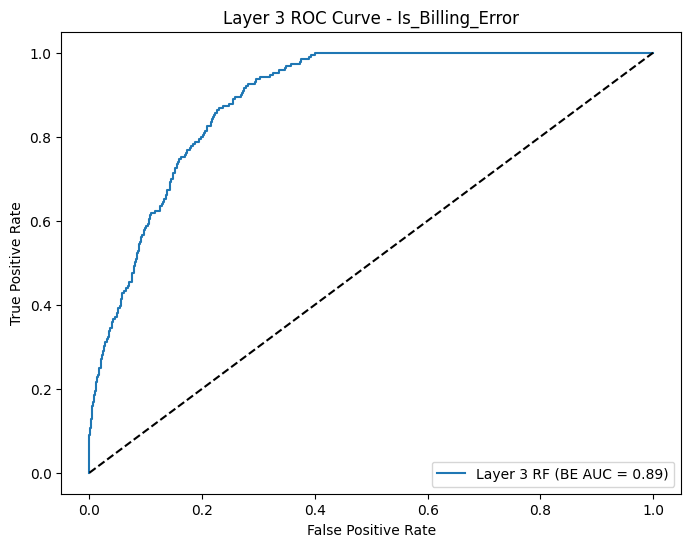

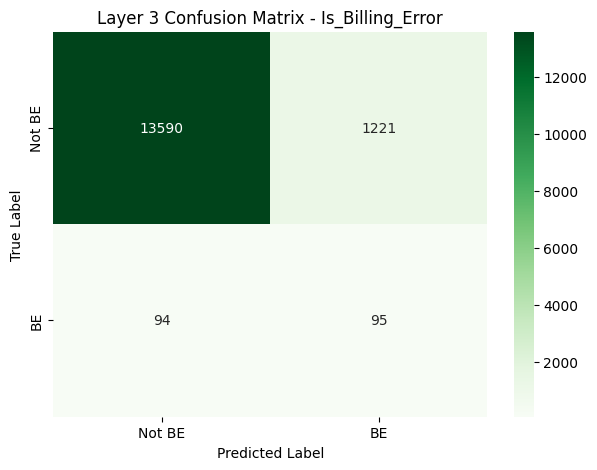


--- Training Layer 3 Model for Billing_Error_Type ---
Training Layer 3 Random Forest model for Billing_Error_Type...
Layer 3 (Billing_Error_Type) model training complete.

Layer 3 Billing_Error_Type Performance (on actual Billing Errors in Test Set):
                               precision    recall  f1-score   support

             Duplicate_Charge       1.00      0.96      0.98        23
Unwanted_Subscription_Renewal       0.99      1.00      1.00       166

                     accuracy                           0.99       189
                    macro avg       1.00      0.98      0.99       189
                 weighted avg       0.99      0.99      0.99       189



In [4]:
print("\n--- Layer 3: Billing Anomaly Detector (Random Forest) ---")

# --- Feature Selection for Layer 3 ---
# Focus on features relevant to duplicates, subscriptions, merchant billing history
layer3_numerical_features = [
    'Transaction_Amount_Local_Currency', 'Is_Card_Present',
    'Billing_Dispute_History_Count', # CH specific
    'Historical_Billing_Dispute_Rate_Global', # Merchant specific
    'Time_Since_CH_Last_Transaction_Overall_Min',
    'Time_Since_CH_Last_Transaction_at_Same_Merchant_Min', # Key for duplicates
    'Transaction_Hour',
    # Include Layer 1's output if deemed useful (and if run on training data too)
    # For now, keeping it independent like Layer 2
]
# Add windowed velocity features for general context
for window_hr in window_sizes_hours: # Defined in Part 1
    layer3_numerical_features.append(f'CH_Count_Transactions_Last_{window_hr}H')
    layer3_numerical_features.append(f'CH_Sum_Amount_Transactions_Last_{window_hr}H')


layer3_categorical_features = [
    'Merchant_Category_Code', 'Point_of_Sale_Entry_Mode',
    'Transaction_Country_Code', 'Country_Code_CH',
    'Persona_Type', 'Merchant_Risk_Level', # General risk might correlate with billing issues
    'Transaction_DayOfWeek'
    # 'Transaction_Descriptor_Raw_Text' - if we had more advanced NLP features from it
    # 'Is_Recurring_Payment_Flag' - if we had simulated this (good feature for real data)
    # 'Is_First_Recurring_Payment' - if we had simulated this
]

# Ensure selected features exist
layer3_numerical_features = [f for f in layer3_numerical_features if f in train_df.columns]
layer3_categorical_features = [f for f in layer3_categorical_features if f in train_df.columns]

# --- Create Preprocessor for Layer 3 ---
preprocessor_l3 = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, layer3_numerical_features), # Using StandardScaler
        ('cat', categorical_transformer, layer3_categorical_features)
    ],
    remainder='drop' # Drop other columns not used by this layer
)

# --- Prepare Data for Layer 3 ---
# Target 1: Is_Billing_Error (Binary)
features_l3 = layer3_numerical_features + layer3_categorical_features
X_train_l3 = train_df[features_l3].copy()
y_train_l3_be = train_df[TARGET_BILLING_ERROR].copy()

X_test_l3 = test_df[features_l3].copy()
y_test_l3_be_actual = test_df[TARGET_BILLING_ERROR].copy()

# Apply preprocessing
X_train_l3_processed = preprocessor_l3.fit_transform(X_train_l3)
X_test_l3_processed = preprocessor_l3.transform(X_test_l3)

print(f"Shape of preprocessed training data for L3 (Billing Error): {X_train_l3_processed.shape}")
print(f"Shape of preprocessed test data for L3 (Billing Error): {X_test_l3_processed.shape}")

# --- Random Forest Model for Is_Billing_Error ---
billing_error_ratio_train = y_train_l3_be.value_counts(normalize=True)
print(f"Billing Error ratio in L3 training data: \n{billing_error_ratio_train}")

# RandomForest can handle imbalance somewhat with class_weight='balanced'
rf_l3_be_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=10,
    random_state=42,
    class_weight='balanced', # Good for imbalanced classes
    n_jobs=-1, # Use all available cores
    verbose=0
)

print("\nTraining Layer 3 Random Forest model for Is_Billing_Error...")
rf_l3_be_model.fit(X_train_l3_processed, y_train_l3_be)
print("Layer 3 (Is_Billing_Error) model training complete.")

# --- Predictions and Evaluation for Is_Billing_Error ---
y_pred_l3_be_proba = rf_l3_be_model.predict_proba(X_test_l3_processed)[:, 1]
y_pred_l3_be_class = rf_l3_be_model.predict(X_test_l3_processed)

test_df['Layer3_Billing_Error_Probability'] = y_pred_l3_be_proba
test_df['Layer3_Billing_Error_Prediction'] = y_pred_l3_be_class

print("\nLayer 3 Is_Billing_Error Performance (on Test Set):")
print(classification_report(y_test_l3_be_actual, y_pred_l3_be_class, target_names=['Not Billing Error', 'Billing Error']))

try:
    roc_auc_l3_be = roc_auc_score(y_test_l3_be_actual, y_pred_l3_be_proba)
    print(f"Layer 3 (Is_Billing_Error) ROC AUC Score: {roc_auc_l3_be:.4f}")
except ValueError as e:
    print(f"Could not calculate ROC AUC for Layer 3 (Is_Billing_Error): {e}")
    roc_auc_l3_be = None

if roc_auc_l3_be is not None:
    fpr, tpr, _ = roc_curve(y_test_l3_be_actual, y_pred_l3_be_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Layer 3 RF (BE AUC = {roc_auc_l3_be:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Layer 3 ROC Curve - Is_Billing_Error')
    plt.legend(loc='lower right')
    plt.show()

# Confusion Matrix for Is_Billing_Error
cm_l3_be = confusion_matrix(y_test_l3_be_actual, y_pred_l3_be_class)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_l3_be, annot=True, fmt='d', cmap='Greens', xticklabels=['Not BE', 'BE'], yticklabels=['Not BE', 'BE'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Layer 3 Confusion Matrix - Is_Billing_Error')
plt.show()


# --- Optional: Model for Billing_Error_Type (Multi-class) ---
# Only train this on actual billing errors to predict the type
train_df_be_only = train_df[train_df[TARGET_BILLING_ERROR] == 1].copy()
if not train_df_be_only.empty and 'Billing_Error_Type' in train_df_be_only.columns and train_df_be_only['Billing_Error_Type'].nunique() > 1:
    print("\n--- Training Layer 3 Model for Billing_Error_Type ---")
    X_train_l3_betype = train_df_be_only[features_l3].copy() # Use same features
    y_train_l3_betype = train_df_be_only['Billing_Error_Type'].copy().fillna('Unknown') # Fill NaNs for target

    # Preprocess
    X_train_l3_betype_processed = preprocessor_l3.transform(X_train_l3_betype) # Use already fitted preprocessor

    rf_l3_betype_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=8,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1,
        verbose=0
    )
    print("Training Layer 3 Random Forest model for Billing_Error_Type...")
    rf_l3_betype_model.fit(X_train_l3_betype_processed, y_train_l3_betype)
    print("Layer 3 (Billing_Error_Type) model training complete.")

    # Predict on test set transactions that were *predicted* as billing errors by the first L3 model
    # Or, for evaluation, predict on all test transactions and then filter by actual billing errors
    test_df_be_actual_only = test_df[test_df[TARGET_BILLING_ERROR] == 1].copy()
    if not test_df_be_actual_only.empty :
        X_test_l3_betype = test_df_be_actual_only[features_l3].copy()
        y_test_l3_betype_actual = test_df_be_actual_only['Billing_Error_Type'].copy().fillna('Unknown')

        X_test_l3_betype_processed = preprocessor_l3.transform(X_test_l3_betype)
        y_pred_l3_betype_class = rf_l3_betype_model.predict(X_test_l3_betype_processed)

        print("\nLayer 3 Billing_Error_Type Performance (on actual Billing Errors in Test Set):")
        print(classification_report(y_test_l3_betype_actual, y_pred_l3_betype_class))
        
        # Add this prediction to the main test_df for those records predicted as Billing Error by the BE model
        # For simplicity, we'll make a general prediction on all test_df and then use it if Layer3_Billing_Error_Prediction is 1
        all_X_test_l3_betype_processed = preprocessor_l3.transform(test_df[features_l3]) # Transform all test data
        all_y_pred_l3_betype_class = rf_l3_betype_model.predict(all_X_test_l3_betype_processed)
        test_df['Layer3_Predicted_Error_Type'] = all_y_pred_l3_betype_class
        # Only keep the predicted type if the BE model also flagged it as a billing error
        test_df.loc[test_df['Layer3_Billing_Error_Prediction'] == 0, 'Layer3_Predicted_Error_Type'] = None
    else:
        print("No actual billing errors in test set to evaluate Billing_Error_Type model.")
        test_df['Layer3_Predicted_Error_Type'] = None # No predictions to make

else:
    print("Skipping Billing_Error_Type model: not enough data or distinct types in training set.")
    test_df['Layer3_Predicted_Error_Type'] = None

**Explanation of Layer 3 Code:**

1.  **Feature Selection:**
    *   We select features that are more likely to indicate billing issues. This includes `Time_Since_CH_Last_Transaction_at_Same_Merchant_Min` (key for duplicates), `Historical_Billing_Dispute_Rate_Global`, and general cardholder/transaction context.
    *   Ideally, features derived from `Transaction_Descriptor_Raw_Text` (e.g., presence of keywords like "TRIAL," "RECURRING," "AUTORENEW") and flags like `Is_Recurring_Payment_Flag` would be very powerful here. Our simulation is basic in this aspect, so the model will rely more on other patterns.
2.  **Preprocessor (`preprocessor_l3`):** Similar to Layer 2, using `StandardScaler` and `OneHotEncoder`.
3.  **Data Preparation:**
    *   The primary target is `Is_Billing_Error`.
    *   `X_train_l3` and `X_test_l3` are prepared.
4.  **Random Forest Model for `Is_Billing_Error` (`rf_l3_be_model`):**
    *   `RandomForestClassifier` is chosen.
    *   `class_weight='balanced'` is used to help address the imbalance in the `Is_Billing_Error` target.
5.  **Training and Evaluation:**
    *   The model is trained to predict whether a transaction is a billing error.
    *   Standard classification metrics (report, ROC AUC, confusion matrix) are used for evaluation.
6.  **Optional: Model for `Billing_Error_Type`:**
    *   A second RandomForest model (`rf_l3_betype_model`) is trained *only on transactions that are actual billing errors* in the training set (`train_df_be_only`).
    *   Its goal is to classify the *type* of billing error (e.g., `Duplicate_Charge`, `Unwanted_Subscription_Renewal`).
    *   This model's predictions are then applied to the test set. We store `Layer3_Predicted_Error_Type` in `test_df`, but it's only meaningful if `Layer3_Billing_Error_Prediction` is also 1.
7.  **Output:** `Layer3_Billing_Error_Probability`, `Layer3_Billing_Error_Prediction`, and `Layer3_Predicted_Error_Type` are added to `test_df`. These provide nuanced information about potential billing issues.

This completes the modeling for the primary detection layers. The final step is conceptualizing Layer 4 (Decision & Action Engine), which would use the outputs of Layers 1, 2, and 3.

## Part 5: Layer 4: The "Decision & Action Engine".
This layer isn't typically a single, complex ML model trained from scratch like the previous ones. Instead, it's a system that **integrates the outputs (scores/probabilities) from Layers 1, 2, and 3** to make a final, informed decision and suggest an appropriate action.

**Objectives of Layer 4:**

1.  **Synthesize Information:** Combine potentially conflicting or complementary signals from the specialized upstream layers.
2.  **Apply Business Logic:** Incorporate bank-specific rules, risk appetite, and customer segmentation.
3.  **Dynamic Thresholding:** Allow for adjustment of decision boundaries based on current risk levels or specific scenarios.
4.  **Action Prioritization:** Determine the most appropriate response (e.g., decline, alert, flag for review, step-up authentication).

**Approaches for Layer 4:**

1.  **Rule-Based System:**
    *   **How it works:** A set of predefined `IF-THEN-ELSE` rules based on the scores from Layers 1, 2, and 3, and other contextual variables (e.g., transaction amount, customer value).
    *   **Example Rules:**
        *   `IF Layer2_Fraud_Probability > 0.9 THEN DeclineTransaction AND AlertUser`
        *   `IF Layer2_Fraud_Probability > 0.6 AND Layer1_Reconstruction_Error > THRESHOLD_HIGH THEN StepUpAuthentication`
        *   `IF Layer3_Billing_Error_Probability > 0.8 AND Layer2_Fraud_Probability < 0.2 THEN FlagForCustomerReview ("Does this look right?")`
        *   `IF Layer3_Predicted_Error_Type == 'Duplicate_Charge' AND Layer3_Billing_Error_Probability > 0.7 THEN FlagForAnalystReview`
    *   **Pros:** Transparent, easy to understand and modify by business users.
    *   **Cons:** Can become very complex to manage, may not capture subtle interactions between scores, requires manual tuning.

2.  **Weighted Scoring System:**
    *   **How it works:** Assign weights to the scores from each layer and combine them into a final risk score.
    *   **Example:** `Final_Risk_Score = (w1 * Layer1_Anomaly_Score_Normalized) + (w2 * Layer2_Fraud_Probability) + (w3 * Layer3_Billing_Error_Probability)`
    *   Different thresholds on `Final_Risk_Score` trigger different actions.
    *   **Pros:** Simpler than extensive rule sets.
    *   **Cons:** Determining optimal weights can be challenging, might oversimplify.

3.  **Meta-Learner (Stacking):**
    *   **How it works:** Train a simple machine learning model (the meta-learner, e.g., Logistic Regression, a shallow Decision Tree, or even a simple Neural Network) using the outputs (probabilities/scores) from Layers 1, 2, and 3 as its input features. The target for this meta-learner would be the ultimate desired outcome (e.g., a combined "action code" or a refined "final risk level").
    *   **Data for Meta-Learner:**
        *   **Features:** `Layer1_Reconstruction_Error`, `Layer2_Fraud_Probability`, `Layer3_Billing_Error_Probability`. You could also include the original transaction amount or other key context.
        *   **Target:** This is the trickiest part. You need a "ground truth" for the *optimal combined decision*. This might come from:
            *   Historical data where human analysts made final decisions based on various alerts.
            *   Simulating optimal actions based on the known `Is_Fraud` and `Is_Billing_Error` flags and a predefined cost matrix (e.g., cost of a false positive vs. cost of a missed fraud).
    *   **Pros:** Can learn optimal ways to combine the signals from previous layers, potentially capturing non-linear interactions.
    *   **Cons:** Requires careful setup of training data and target definition, can be less transparent than rules.

**Let's implement a simple Meta-Learner (Logistic Regression) for demonstration.**

**Assumptions for the Meta-Learner:**

*   We'll create a simplified target for the meta-learner. Let's define a combined "High_Risk_Event" if either `Is_Fraud` is true OR `Is_Billing_Error` is true (and it's a significant billing error). This is a simplification; a real system would have more nuanced action targets.
*   We need to generate predictions from Layers 1, 2, and 3 on a *validation set* (or use cross-validation predictions on the training set) to train the meta-learner. Using predictions from models on the same data they were trained on to train a meta-learner leads to leakage and overly optimistic results.

**Since we've already added Layer 1, 2, and 3 predictions to our `test_df`, we can use a portion of this `test_df` as a "holdout validation set" to train the meta-learner, and then evaluate on the remainder of `test_df`. This isn't ideal (ideally, we'd have a separate validation set from the start), but it's feasible for this demonstration.**


--- Layer 4: Decision & Action Engine (Meta-Learner Conception) ---
Meta-Train set shape: (7500, 56)
Meta-Test set shape: (7500, 56)
Shape of preprocessed meta-training data: (7500, 4)

Training Layer 4 Meta-Learner...
Layer 4 Meta-Learner training complete.

Layer 4 Meta-Learner Performance (on Meta-Test Set for 'High_Risk_Event'):
               precision    recall  f1-score   support

Not High Risk       0.99      0.77      0.87      7301
    High Risk       0.09      0.82      0.16       199

     accuracy                           0.77      7500
    macro avg       0.54      0.79      0.51      7500
 weighted avg       0.97      0.77      0.85      7500

Layer 4 Meta-Learner ROC AUC Score: 0.8843

Example Suggested Actions based on Layer 4 Meta-Learner Output:
       Layer1_Reconstruction_Error  Layer2_Fraud_Probability  \
67500                     0.004391                  0.000549   
67501                     0.004379                  0.002859   
67502                     0.004

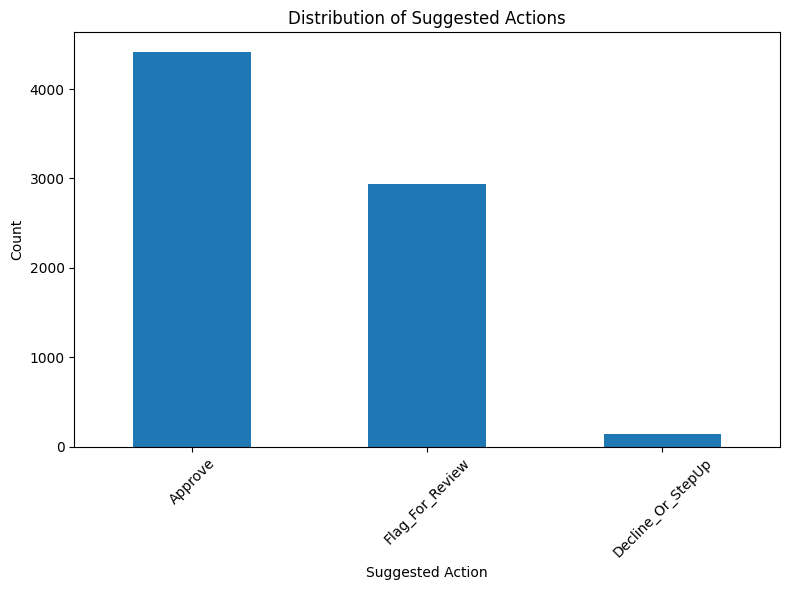

In [5]:
print("\n--- Layer 4: Decision & Action Engine (Meta-Learner Conception) ---")

# For this demonstration, we'll split our current test_df further
# to get a "meta_train_df" (for training the meta-learner) and a "meta_test_df" (for evaluating it)
# This simulates having a validation set with predictions from L1, L2, L3.

if 'Layer1_Reconstruction_Error' not in test_df.columns or \
   'Layer2_Fraud_Probability' not in test_df.columns or \
   'Layer3_Billing_Error_Probability' not in test_df.columns:
    print("Error: Outputs from Layers 1, 2, or 3 are missing in test_df. Cannot proceed with Layer 4.")
    # In a real pipeline, ensure these are populated.
    # For now, if they are missing, we'll create dummy columns for the code to run.
    if 'Layer1_Reconstruction_Error' not in test_df.columns: test_df['Layer1_Reconstruction_Error'] = np.random.rand(len(test_df))
    if 'Layer2_Fraud_Probability' not in test_df.columns: test_df['Layer2_Fraud_Probability'] = np.random.rand(len(test_df))
    if 'Layer3_Billing_Error_Probability' not in test_df.columns: test_df['Layer3_Billing_Error_Probability'] = np.random.rand(len(test_df))
    print("Dummy L1/L2/L3 outputs created in test_df for Layer 4 demonstration.")


meta_split_point = int(len(test_df) * 0.5) # Use 50% of test_df for meta-training
meta_train_df = test_df.iloc[:meta_split_point].copy()
meta_test_df = test_df.iloc[meta_split_point:].copy()

print(f"Meta-Train set shape: {meta_train_df.shape}")
print(f"Meta-Test set shape: {meta_test_df.shape}")

# --- Define Features and Target for Meta-Learner ---
meta_features = [
    'Layer1_Reconstruction_Error',
    'Layer2_Fraud_Probability',
    'Layer3_Billing_Error_Probability',
    'Transaction_Amount_Local_Currency' # Example: include original transaction amount
]
# Ensure features exist
meta_features = [f for f in meta_features if f in meta_train_df.columns]


# Define a simplified combined target: "High_Risk_Event"
# 1 if it's fraud OR a significant billing error (e.g., probability > 0.5 from L3)
# This is a simplification for demonstration.
meta_train_df['Meta_Target_High_Risk'] = (
    (meta_train_df[TARGET_FRAUD] == 1) |
    (meta_train_df[TARGET_BILLING_ERROR] == 1) # Simplified: any billing error is high risk for this target
).astype(int)

meta_test_df['Meta_Target_High_Risk'] = (
    (meta_test_df[TARGET_FRAUD] == 1) |
    (meta_test_df[TARGET_BILLING_ERROR] == 1)
).astype(int)

X_meta_train = meta_train_df[meta_features].copy()
y_meta_train = meta_train_df['Meta_Target_High_Risk'].copy()

X_meta_test = meta_test_df[meta_features].copy()
y_meta_test_actual = meta_test_df['Meta_Target_High_Risk'].copy()

# --- Preprocessing for Meta-Learner (usually just scaling) ---
# Impute NaNs that might arise from layer predictions (though ideally they shouldn't)
meta_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

X_meta_train_processed = meta_preprocessor.fit_transform(X_meta_train)
X_meta_test_processed = meta_preprocessor.transform(X_meta_test)

print(f"Shape of preprocessed meta-training data: {X_meta_train_processed.shape}")

# --- Meta-Learner Model (Logistic Regression) ---
meta_learner = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')

print("\nTraining Layer 4 Meta-Learner...")
meta_learner.fit(X_meta_train_processed, y_meta_train)
print("Layer 4 Meta-Learner training complete.")

# --- Predictions and Evaluation for Meta-Learner ---
y_pred_meta_proba = meta_learner.predict_proba(X_meta_test_processed)[:, 1]
y_pred_meta_class = meta_learner.predict(X_meta_test_processed)

meta_test_df['Layer4_Final_Risk_Probability'] = y_pred_meta_proba
meta_test_df['Layer4_Final_Risk_Prediction'] = y_pred_meta_class

print("\nLayer 4 Meta-Learner Performance (on Meta-Test Set for 'High_Risk_Event'):")
print(classification_report(y_meta_test_actual, y_pred_meta_class, target_names=['Not High Risk', 'High Risk']))

try:
    roc_auc_meta = roc_auc_score(y_meta_test_actual, y_pred_meta_proba)
    print(f"Layer 4 Meta-Learner ROC AUC Score: {roc_auc_meta:.4f}")
except ValueError as e:
    print(f"Could not calculate ROC AUC for Layer 4: {e}")
    roc_auc_meta = None
    
# --- Example of how to use the meta-learner's output for actions ---
# This is where you'd define thresholds for actions
final_decision_threshold_high_risk = 0.7 # Example: if prob > 0.7, take strong action
final_decision_threshold_medium_risk = 0.4 # Example: if prob > 0.4, flag for review

meta_test_df['Suggested_Action'] = 'Approve'
meta_test_df.loc[meta_test_df['Layer4_Final_Risk_Probability'] > final_decision_threshold_medium_risk, 'Suggested_Action'] = 'Flag_For_Review'
meta_test_df.loc[meta_test_df['Layer4_Final_Risk_Probability'] > final_decision_threshold_high_risk, 'Suggested_Action'] = 'Decline_Or_StepUp'

print("\nExample Suggested Actions based on Layer 4 Meta-Learner Output:")
print(meta_test_df[['Layer1_Reconstruction_Error', 'Layer2_Fraud_Probability', 'Layer3_Billing_Error_Probability',
                    TARGET_FRAUD, TARGET_BILLING_ERROR, # Actuals
                    'Layer4_Final_Risk_Probability', 'Suggested_Action']].head(20))

print("\nDistribution of Suggested Actions:")
print(meta_test_df['Suggested_Action'].value_counts())

import matplotlib.pyplot as plt

# Calculate counts directly from the DataFrame column
counts = meta_test_df['Suggested_Action'].value_counts()

# Plot the bar chart
plt.figure(figsize=(8, 6))
counts.plot(kind='bar')
plt.title("Distribution of Suggested Actions")
plt.xlabel("Suggested Action")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Explanation of Layer 4 (Meta-Learner) Code:**

1.  **Data Split:** The existing `test_df` (which now contains predictions from L1, L2, L3) is further split. `meta_train_df` is used to train the meta-learner, and `meta_test_df` is used to evaluate it. This ensures the meta-learner is trained on "out-of-sample" predictions from the base layers.
2.  **Feature Selection:** The inputs (`meta_features`) to the meta-learner are the key outputs from the previous layers:
    *   `Layer1_Reconstruction_Error`
    *   `Layer2_Fraud_Probability`
    *   `Layer3_Billing_Error_Probability`
    *   We also included `Transaction_Amount_Local_Currency` as an example of how other raw features can provide context to the meta-learner.
3.  **Target Definition (`Meta_Target_High_Risk`):**
    *   This is crucial and often the most complex part to define for a meta-learner.
    *   For this demonstration, we created a simple binary target: `1` if the transaction was *actually* fraudulent (`Is_Fraud == 1`) OR if it was *actually* a billing error (`Is_Billing_Error == 1`). This treats both as a "high-risk event" we want the meta-learner to identify.
    *   In a real system, you might have multiple target classes representing different actions (e.g., 0=Approve, 1=Flag, 2=Step-Up, 3=Decline) and train a multi-class meta-learner, or have separate meta-learners for different types of risk.
4.  **Preprocessing:** The input features to the meta-learner are scaled using `StandardScaler`.
5.  **Meta-Learner Model:** A `LogisticRegression` model is used. It's simple, interpretable, and often works well as a meta-learner. `class_weight='balanced'` is used as the `Meta_Target_High_Risk` might also be imbalanced.
6.  **Training and Evaluation:**
    *   The meta-learner is trained on `X_meta_train_processed` and `y_meta_train`.
    *   It's evaluated on `X_meta_test_processed` against `y_meta_test_actual`.
    *   Standard classification metrics are reported.
7.  **Suggested Actions:**
    *   The code demonstrates how the `Layer4_Final_Risk_Probability` from the meta-learner can be used with simple thresholds to determine a `Suggested_Action`. This is where the business logic and risk appetite of the bank would heavily influence the thresholds.

**Next Steps and Considerations for a Real System:**

*   **Proper Stacking Implementation:** For robust stacking, predictions for the meta-learner's training data should come from cross-validation on the original training set (to avoid leakage). Base models (L1, L2, L3) are trained on K-1 folds, predict on the Kth fold, and these out-of-fold predictions form the features for the meta-learner. Then, the base models are retrained on all training data to make predictions on the final test set.
*   **More Sophisticated Target for Meta-Learner:** Consider a cost-benefit analysis to define the target variable or use human analyst decisions as the ground truth.
*   **Dynamic Thresholding:** Thresholds for `Suggested_Action` should not be static. They could be adjusted based on:
    *   Overall fraud trends.
    *   Customer segments (e.g., higher tolerance for high-value customers).
    *   Specific merchant risk.
*   **Explainability (XAI):** For a system making critical financial decisions, understanding *why* a decision was made is important (e.g., using SHAP values for the meta-learner or even the base learners).
*   **Feedback Loop:** The actual outcomes of the `Suggested_Action` (was it correct? did the customer confirm fraud? was the billing error resolved?) are vital for retraining ALL layers of the system.

This multi-layered approach provides a powerful and flexible framework. We've now prototyped the core ML components for each detection stage and a way to combine their insights!